# Multi-label Text Classification - Deep Learning Models

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional

from wordcloud import WordCloud 
import wordcloud
from PIL import Image

from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords

import tensorflow as tf
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


#### Variable declarations:

In [2]:
np.random.seed(1234)   # To get the same result every time
random_rows = 5000     # number of rows to read from the csv file
max_seq_length = 300   # Maximum comment size
max_words = 50000      # Maximum vocabulary (word) size
embed_dim = 300        # Maximum Embedding Dimension

## 1) LOAD DATA

### Reading the Input File:

In [3]:
df = pd.read_csv('train.csv', encoding = "ISO-8859-1", nrows = random_rows) 
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
len(df)

5000

#### Finding the number of Unlabelled comments :

In [5]:
print("Percentage of input comments that haven't been labelled:")
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) 
             & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of input comments that haven't been labelled:
0.8924


#### Finding if the comments column has any null values:

In [6]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

#### Fixing the short forms/word contractions:

In [7]:
expansion_list = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have",
    "https": " ",
    "co": " ",
    "the": " ",
    "it": " "
}

word_expansions = re.compile('(%s)' % '|'.join(expansion_list.keys()))

def expandContractions(text, c_re=word_expansions):
    def replace(match):
        return expansion_list[match.group(0)]
    return word_expansions.sub(replace, text)

#### Data Pre-Processing/Data Cleansing :

In [8]:
def text_cleaning(comment_text):
    cleaned_text = []
    for text in comment_text:
        text = str(text)
        
        # Tokenization and removal of stop words :
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(text) 
        sent = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(sent)

        # Removing all the hashtags, @mentions and digits :
        text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|[^a-zA-Z]", " ", text).split())
        text = ' '.join([w for w in text.split() if len(w)>3])
        
        # Lemmatization to generalize the words :
        lemmatizer = WordNetLemmatizer()
        sentence = [lemmatizer.lemmatize(word) for word in text]
        text = ''.join(sentence)

        cleaned_text.append(text)

    return cleaned_text

In [9]:
text_arr = [x for x in df['comment_text']]
text_arr[:2]
type(text_arr[0])

str

#### Calling the Data pre-processing function :

In [10]:
X_text = text_cleaning(text_arr)

#### Reading the first 5 comments after data pre-processing :

In [11]:
X_text[:5]

['Explanation edits made username Hardcore Metallica reverted They vandalisms closure voted York Dolls please remove template talk page since retired',
 'matches background colour seemingly stuck Thanks talk January',
 'really trying edit constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'More make real suggestions improvement wondered section statistics later subsection types accidents think references need tidying exact format date format later else first preferences formatting style references want please know There appears backlog articles review guess delay reviewer turns listed relevant form Wikipedia Good article nominations Transport',
 'hero chance remember page']

In [12]:
len(X_text)

5000

#### Finding out the most commonly used words in the comments :

In [13]:
data_set = ' '.join(x for x in X_text)
split_data = data_set.split()
counter_variable = Counter(split_data)
  
# input values and their respective counts.
most_occur = counter_variable.most_common(10)
  
print(most_occur)

[('article', 1741), ('page', 1470), ('Wikipedia', 1179), ('would', 981), ('like', 941), ('talk', 867), ('think', 607), ('know', 600), ('edit', 549), ('This', 522)]


#### Plotting the most commonly used words in the comments :

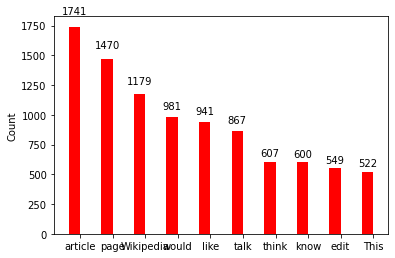

In [14]:
names, values = zip(*most_occur)  
ind = np.arange(len(most_occur))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, values, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(names)



def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)

plt.show()

#### Finding out the number of comments available for each category :

In [15]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,503
1,severe_toxic,51
2,obscene,270
3,threat,20
4,insult,271
5,identity_hate,49


Text(0.5, 0, 'category')

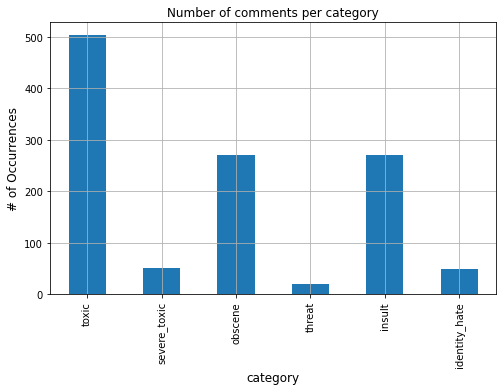

In [16]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

#### Observations : The dataset is very imbalanced.

In [17]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


###  Emoji - Word Cloud:

In [18]:
image_mask = np.array(Image.open("emoji1.png"))

In [19]:
# Create a word cloud image
wc = WordCloud(background_color="black", max_words=300, mask=image_mask, #stopwords=stopwords,
               contour_width=1, contour_color='white')

In [20]:
# Generate a wordcloud
text = ' '.join(review for review in X_text)
wc.generate(text)
#print(text)


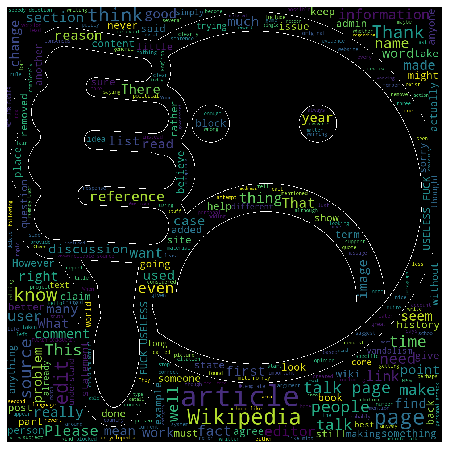

In [21]:
# store to file
#wc.to_file("img/wine.png")

# show
plt.figure(figsize=[10,8])
plt.imshow(wc, interpolation='nearest')
plt.axis("off")
plt.show()   

### Getting the Vector- representations of words (converting words into numbers), in order to feed it to the Neural Network Model :

### Tokenization


##### Sentence Tokenization - Tokenizing the sentences into words and generating the vocabulary index dictionaries based on word frequency. Every word in the sentence is given a unique number:

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)

##### tokenizer.texts_to_sequences -> Transforms the above texts into a sequence of integers:

In [23]:
X_text_to_seq = tokenizer.texts_to_sequences(X_text)

In [24]:
len(X_text_to_seq)

5000

##### Word Index: Assigns a unique index to the words :

In [25]:
word_index = tokenizer.word_index
print('Total number of unique tokens = %s ' % len(word_index))

Total number of unique tokens = 21293 


In [26]:
X = pad_sequences(X_text_to_seq, maxlen=max_seq_length)

print('Shape of tensor:', X.shape)


Shape of tensor: (5000, 300)


#### Printing the Array after transforming the text into integers :

In [27]:
X[:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

#### Word-Embeddings:

#### In order to derive the Vector representations of the words in our comments column, we will be using Google's pre-trained model called word2vector.
* For every word, we will look up its corresponding vector representation from word2vec and load it into the embedding_matrix, as shown below:

In [28]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [29]:
words = min(max_words+1, len(word_index)+1)

embedding_matrix = np.zeros((words, embed_dim))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < max_words:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [30]:
print(len(X))

5000


In [31]:
print(len(embedding_matrix))

21294


In [32]:
embedding_matrix.shape

(21294, 300)

In [33]:
X.shape

(5000, 300)

#### Labels (Target variables)

In [34]:
category_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[category_list]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
4995,0,0,0,0,0,0
4996,0,0,0,0,0,0
4997,1,0,0,0,1,0
4998,0,0,0,0,0,0


#### Converting the labels into an Array:

In [35]:
labels = np.array(df[category_list])
labels[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [36]:
X

array([[    0,     0,     0, ...,     2,    50,  3143],
       [    0,     0,     0, ...,    17,     4,   922],
       [    0,     0,     0, ...,  2605,   439,   336],
       ...,
       [    0,     0,     0, ...,  9066,   684,  1143],
       [    0,     0,     0, ...,   113,  7037,   576],
       [    0,     0,     0, ...,   314,   260, 21293]])

In [37]:
len(X)

5000

In [38]:
y = labels
len(y)

5000

#### Data Splitting into Training & Testing datasets :

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

#### Checking the length of the Train/Test datasets:

In [40]:
len(X_train)

3500

In [41]:
len(y_train)

3500

In [42]:
len(X_test)

1500

In [43]:
len(y_test)

1500

#### Checking the shape of the Train/Test datasets:

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3500, 300)
(3500, 6)
(1500, 300)
(1500, 6)


In [45]:
X_train[:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [46]:
y_train[:2]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

## Neural Network Model : CNN + LSTM

##### 1.  The first layer is the Embedding layer, which takes input as the length of the previously defined embedding_matrix, the embedding dimension, weights and the maximum sequence length (i.e., max vocabulary size). The Embedding layer then runs the new embedding vector through a CNN layer. 
##### 2.  Here we have a Convolutional-1D layer with activation as 'relu', followed by a layer of MaxPooling and Dropout in order to reduce Over-fitting of the model. The CNN learns some structure from the sequential data and then passes it into a Bi-directional LSTM layer. 
##### 3.  The next layer is a Bi-directional LSTM. A Bi-directional LSTM is better than the regular LSTM because it reads the input in 2 ways - once from front to back and then from backwards to front. Hence, it preserves the past as well as the future states at any given point of time.
##### 4.  The output of the LSTM layer is then fed into a standard Dense layer for prediction.

* Activation function used is "Sigmoid" => This is because our text classification model has multi-label classifications.
* The last dense layer has 6 layers => since we have 6 labels to be classified.

### Hyperparameters Tuning:


In [47]:
model = Sequential()

# Embedding layer
model.add(Embedding(len(embedding_matrix), embed_dim, weights=[embedding_matrix], 
                            input_length=max_seq_length, trainable=False))

# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM Layer
model.add(Bidirectional(LSTM(units=200, return_sequences=True)))
model.add(Bidirectional(LSTM(units=200, return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))

## Model Compilation:
#### Performance Metrics considered are: 
* Accuracy
* Precision and 
* Recall

#### For any imbalanced dataset, Accuracy is not a good measure of model performance. Metrics such as Precision, Recall, F1-score are more appropriate.

#### Also, the Loss function to be used is 'binary_crossentropy'.

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=(['acc'],
             tf.keras.metrics.Precision(), tf.keras.metrics.Recall()))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          6388200   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 400)          372800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               961600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0

#### Model Training:

In [49]:
hist = model.fit(X_train, y_train, \
        validation_data=(X_test, y_test), \
        epochs=8, batch_size=100, \
        verbose=1)

Epoch 1/8
35/35 [==============================] - 90s 3s/step - loss: 0.2240 - acc: 0.5503 - precision: 0.0060 - recall: 0.0024 - val_loss: 0.1434 - val_acc: 0.9913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
35/35 [==============================] - 100s 3s/step - loss: 0.1527 - acc: 0.7400 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1392 - val_acc: 0.9913 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/8
35/35 [==============================] - 92s 3s/step - loss: 0.1346 - acc: 0.7369 - precision: 0.6000 - recall: 0.0036 - val_loss: 0.1057 - val_acc: 0.9913 - val_precision: 0.6667 - val_recall: 0.0059
Epoch 4/8
35/35 [==============================] - 105s 3s/step - loss: 0.0942 - acc: 0.8460 - precision: 0.6832 - recall: 0.3010 - val_loss: 0.0943 - val_acc: 0.9913 - val_precision: 0.8500 - val_recall: 0.2500
Epoch 5/8
35/35 [==============================] - 97s 3s/step - loss: 0.0797 - acc: 0.9371 - precision: 0.7040 - recall: 0.4733 -

#### Model Plots:

#### 1. Accuracy Plot : The Validation Accuracy seems to remain high and constant throughout. The Training Accuracy fluctuates between 94% to 99%.

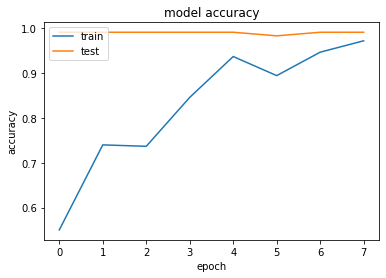

In [50]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 2. Loss :

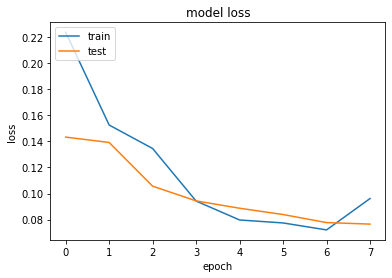

In [51]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 3. Precision Plot : The Precision value is good varying around 75%, upto epoch 5 and later diminishes as the epochs increase.

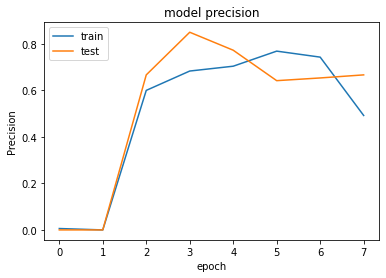

In [52]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 4. Recall Plot : The Recall value isn't very admirable, it varies around 55%.

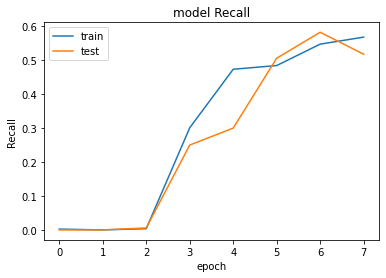

In [53]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Performance Metrics:

In [55]:
X_train.shape

(3500, 300)

In [57]:
np.expand_dims(X_train[43], 0).shape

(1, 300)

In [54]:
predictions = model.predict(np.expand_dims(X_train[43], 0))

print(tokenizer.sequences_to_texts([X_train[43]]))
print(y_train[43])
print(predictions)

['problem think problem someone siting mistress proves point site actual encyclopedia forum encyclopedia difference even pisses page thank single chick bitching would another attorney handing whoever owns site done bitching mistress thing whole page errors first line last line joke first line last line wrong']
[0 0 0 0 0 0]
[[0.36934382 0.01757056 0.11771986 0.00708807 0.16159159 0.02047846]]


In [105]:
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)

In [106]:
len(y_pred)

1500

In [109]:
y_test=np.argmax(y_test, axis=1)
len(y_test)

1500

### Accuracy Metrics :

#### 1. Accuracy - Accuracy is the most widely used performance metric and is simply defined as the ratio of correctly predicted observations to the total number of observations.
* Accuracy = TP+TN/TP+FP+FN+TN

#### 2. Precision - Precision is basically the ratio of True Positives to the total predicted positive observations. 
* Precision = TP/TP+FP
#### With the help of Precision, we can answer the below question - 
#### Of all the toxic text classified, how many were really related to toxic categories? High precision value relates to a low false positive rate. 


#### 3. Recall - Recall is basically the ratio of True Positives to all observations in the True class. 
* Recall = TP/TP+FN
#### With the help of Recall, we can answer the below question - 
####  Of all the classified text, how many have been correctly classified by our Model? High precision value relates to a low false positive rate. 

#### Average method = "micro" :

In [111]:
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("F1 score = ",f1_score(y_test,y_pred, average="micro"))
print ("Precison is", metrics.precision_score(y_test,y_pred, average='micro'))
print ("Recall is", metrics.recall_score(y_test,y_pred, average='micro'))

Accuracy =  0.9913333333333333
F1 score =  0.9913333333333333
Precison is 0.9913333333333333
Recall is 0.9913333333333333


#### Average method = "macro" :

In [112]:
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("F1 score = ",f1_score(y_test,y_pred, average="macro"))
print ("Precison is", metrics.precision_score(y_test,y_pred, average='macro'))
print ("Recall is", metrics.recall_score(y_test,y_pred, average='macro'))

Accuracy =  0.9913333333333333
F1 score =  0.1991295614328758
Precison is 0.19826666666666665
Recall is 0.2
